# New York Stock Exchange: Time-Series Forecasting

## Project Overview
This project focuses on developing a robust Deep Learning pipeline to forecast stock prices using data from the New York Stock Exchange (NYSE). Utilizing historical daily price data (Open, High, Low, Close, and Volume), we aim to predict future closing prices. The workflow is designed to be rigorous, covering data validation, exploratory analysis, advanced feature engineering, and model deployment.

**Dataset**: The analysis uses the [Kaggle NYSE dataset](https://www.kaggle.com/datasets/dgawlik/nyse), specifically `prices-split-adjusted.csv`.

### Methodology: Why Long Short-Term Memory (LSTM)?
Financial time-series data is inherently noisy and non-stationary. Traditional feed-forward networks often fail to capture the temporal dependencies—the "story" of the price movement over time.

We selected **Long Short-Term Memory (LSTM)** networks over Vanilla RNNs and GRUs for the following reasons:
1.  **Long-Term Dependencies**: Vanilla RNNs suffer from the vanishing gradient problem, making them unable to remember patterns from 30+ days ago. LSTMs possess an internal cell state efficiently managed by gates (Input, Forget, Output), allowing them to retain critical trend information over long sequences.
2.  **Complexity Handling**: While GRUs are computationally cheaper, LSTMs generally offer superior performance on complex, volatile datasets like stock markets due to their separate memory cell and hidden state.

![RNN vs LSTM vs GRU Comparison](RNN%20vs%20LSTM%20vs%20GRU.png)

### Architecture: Stacked LSTM
To capture patterns at different levels of abstraction, we implement a **Stacked LSTM** architecture:
- **Layer 1**: Captures low-level temporal features and short-term volatility.
- **Layer 2**: Integrates these features to understand broader market trends.

### System Flow Diagram

```text
                  Global Trend Integration
                          │
       Target Output ──── (L2_30)
                          ▲  ▲
Recurrent Flow (Time) ────│──┘
                          │ 
    [Layer 2: Context]  (h2) ──► (h2) ──► ... ──► (h2)
                          ▲       ▲                ▲
                          │       │                │
    [Layer 1: Sensor]   (h1) ──► (h1) ──► ... ──► (h1)
                          ▲       ▲                ▲
                          │       │                │
    [Input Markets]     [X_1]   [X_2]            [X_30]
                       t=1     t=2              t=30
```


---

## 1. Environment Setup
We begin by importing the necessary libraries for data manipulation (Pandas), numerical computing (NumPy), and deep learning (TensorFlow/Keras). We also configure the plotting environment using Matplotlib with a dark theme for high-quality visualizations and set random seeds to ensure the reproducibility of our results.

In [1]:
import os
import json
import pickle
import random
from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

# ==============================
# Reproducibility
# ==============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==============================
# Matplotlib dark theme
# ==============================
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": "#111111",
        "axes.facecolor": "#111111",
        "axes.edgecolor": "#444444",
        "axes.labelcolor": "#E0E0E0",
        "axes.titlecolor": "#FFFFFF",
        "xtick.color": "#D0D0D0",
        "ytick.color": "#D0D0D0",
        "grid.color": "#2B2B2B",
        "grid.alpha": 0.55,
        "grid.linestyle": "--",
    }
)


def style_axis(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, pad=10)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


def draw_candlestick(ax, frame, width=0.6):
    x = mdates.date2num(frame["date"])
    for xi, o, h, l, c in zip(x, frame["open"], frame["high"], frame["low"], frame["close"]):
        color = "#2ECC71" if c >= o else "#E74C3C"
        ax.vlines(xi, l, h, color=color, linewidth=1.0, alpha=0.95)
        lower = min(o, c)
        height = max(abs(c - o), 1e-8)
        rect = Rectangle((xi - width / 2, lower), width, height, facecolor=color, edgecolor=color, alpha=0.85)
        ax.add_patch(rect)
    ax.xaxis_date()


2026-02-18 21:15:57.018982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771449357.215664      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771449357.276213      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771449357.776243      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771449357.776292      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771449357.776295      17 computation_placer.cc:177] computation placer alr

## 2. Project Configuration
Here we define the global hyperparameters and constants that control the pipeline. This includes the target ticker symbol, the lookback window size (sequence length), and model training parameters like batch size and epoch count. Centralizing these configurations ensures consistency and ease of experimentation.

In [2]:
DATA_DIR = Path("/kaggle/input/datasets/dgawlik/nyse")
DATA_FILE = DATA_DIR / "prices-split-adjusted.csv"

TICKER = "EQIX"
FEATURE_COLUMNS = ["open", "high", "low", "close", "volume"]
TARGET_COLUMN = "close"
SEQUENCE_LENGTH = 30

TRAIN_RATIO = 0.80
VALID_RATIO = 0.10
TEST_RATIO = 0.10

LSTM_UNITS = 96
LSTM_LAYERS = 2
DROPOUT_RATE = 0.15
BATCH_SIZE = 64
EPOCHS = 40

ARTIFACT_DIR = Path("/kaggle/working/nyse_lstm_artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_FILE.exists():
    raise FileNotFoundError(f"Missing dataset: {DATA_FILE}")

print("Dataset:", DATA_FILE)
print("Artifacts:", ARTIFACT_DIR)


Dataset: /kaggle/input/datasets/dgawlik/nyse/prices-split-adjusted.csv
Artifacts: /kaggle/working/nyse_lstm_artifacts


## 3. Data Ingestion and Validation
We load the raw CSV data and perform initial validation checks. This step is critical to ensure the integrity of the data before processing. We verify the existence of the specific ticker symbol and inspect the data structure to confirm it parses correctly.

In [3]:
market_df = pd.read_csv(DATA_FILE)
market_df["date"] = pd.to_datetime(market_df["date"])

print("Rows:", len(market_df))
print("Unique symbols:", market_df["symbol"].nunique())

available_symbols = sorted(market_df["symbol"].unique())
if TICKER not in available_symbols:
    raise ValueError(f"Ticker '{TICKER}' not found. Example symbols: {available_symbols[:20]}")

ticker_df = (
    market_df.loc[market_df["symbol"] == TICKER, ["date", "symbol"] + FEATURE_COLUMNS]
    .sort_values("date")
    .reset_index(drop=True)
)

ticker_df.head()


Rows: 851264
Unique symbols: 501


,date,symbol,open,high,low,close,volume
0,2010-01-04,EQIX,106.519997,109.620003,106.510002,109.559998,576300.0
1,2010-01-05,EQIX,109.589996,109.589996,108.379997,108.540001,681900.0
2,2010-01-06,EQIX,108.949997,110.570000,108.220001,109.529999,1397500.0
3,2010-01-07,EQIX,109.250000,110.349998,106.639999,107.290001,797200.0
4,2010-01-08,EQIX,106.800003,107.279999,105.900002,106.769997,432400.0


## 4. Exploratory Data Analysis (EDA)
Before modeling, it is essential to understand the underlying behavior of the asset. We generate a combined Candlestick and Volume chart to visualize the price action, identifying potential support/resistance levels and trading intensity over the historical period.

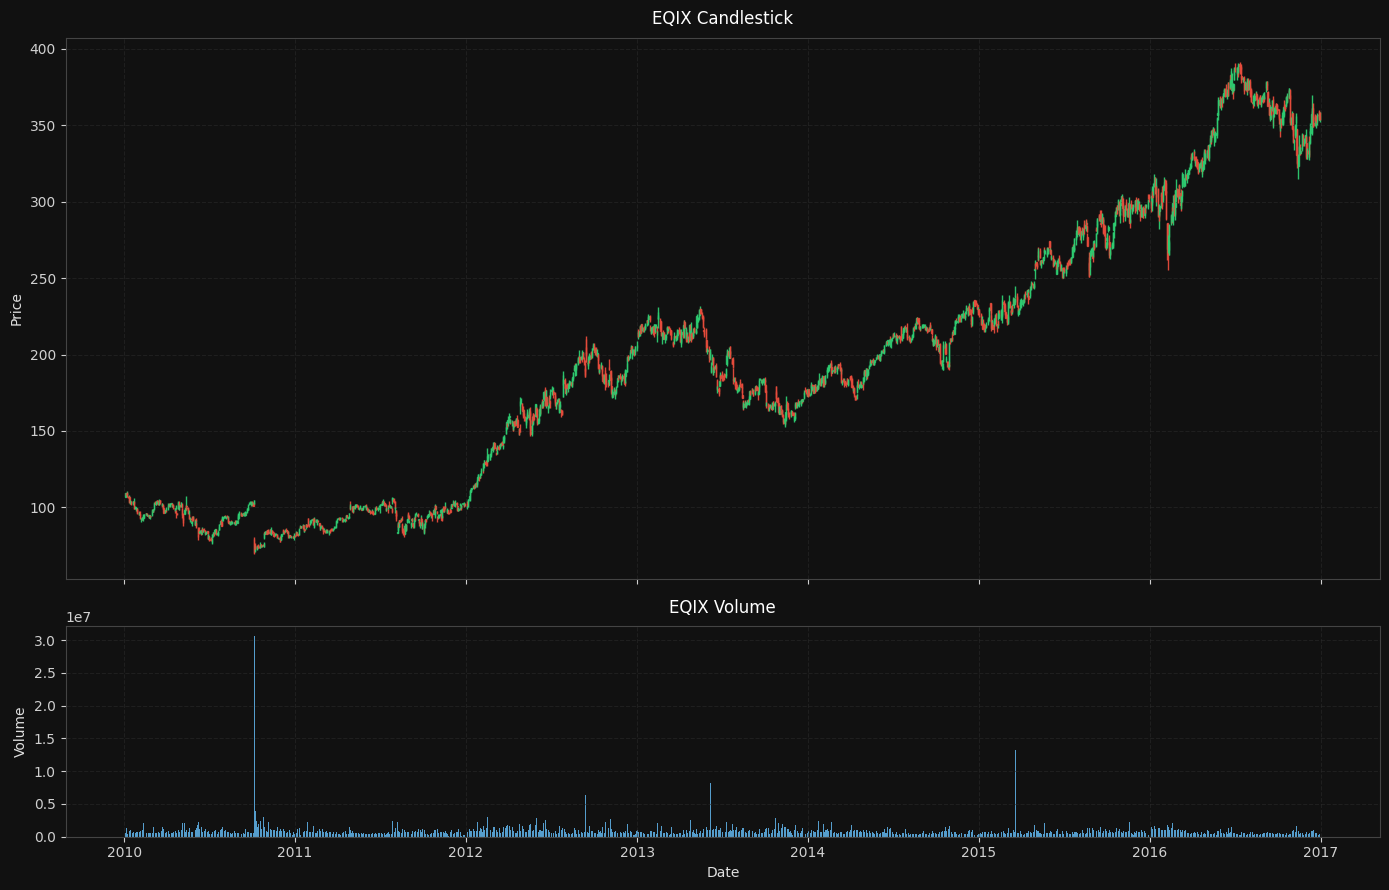

In [4]:
# 4.1 Candlestick + volume overview
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(14, 9),
    sharex=True,
    gridspec_kw={"height_ratios": [0.72, 0.28]},
)

draw_candlestick(ax1, ticker_df)
style_axis(ax1, title=f"{TICKER} Candlestick", ylabel="Price")

ax2.bar(ticker_df["date"], ticker_df["volume"], color="#5DADE2", width=1.0, alpha=0.9)
style_axis(ax2, title=f"{TICKER} Volume", xlabel="Date", ylabel="Volume")

locator = mdates.AutoDateLocator()
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.tight_layout()
plt.show()


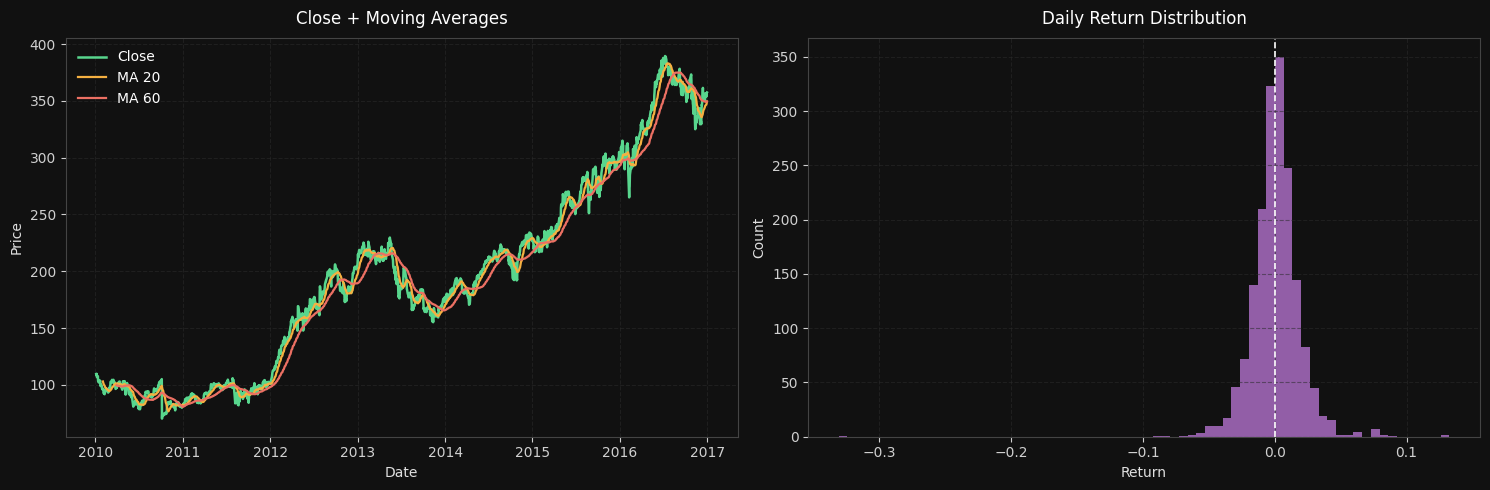

In [5]:
# 4.2 Trend and return structure
viz_df = ticker_df.copy()
viz_df["ma_20"] = viz_df["close"].rolling(20).mean()
viz_df["ma_60"] = viz_df["close"].rolling(60).mean()
viz_df["daily_return"] = viz_df["close"].pct_change()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(viz_df["date"], viz_df["close"], label="Close", color="#58D68D", linewidth=1.8)
axes[0].plot(viz_df["date"], viz_df["ma_20"], label="MA 20", color="#F5B041", linewidth=1.6)
axes[0].plot(viz_df["date"], viz_df["ma_60"], label="MA 60", color="#EC7063", linewidth=1.6)
style_axis(axes[0], title="Close + Moving Averages", xlabel="Date", ylabel="Price")
axes[0].legend(frameon=False)

axes[1].hist(viz_df["daily_return"].dropna(), bins=70, color="#A569BD", alpha=0.88)
axes[1].axvline(0, color="white", linestyle="--", linewidth=1.2)
style_axis(axes[1], title="Daily Return Distribution", xlabel="Return", ylabel="Count")

plt.tight_layout()
plt.show()


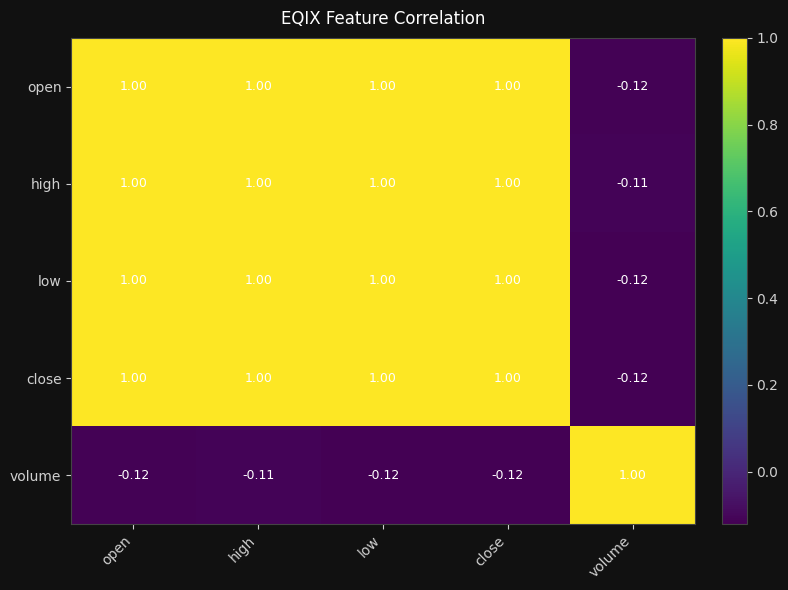

In [6]:
# 4.3 Correlation heatmap
corr = ticker_df[FEATURE_COLUMNS].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, cmap="viridis", aspect="auto")

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", color="white", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.grid(False)
ax.set_title(f"{TICKER} Feature Correlation", pad=10)

plt.tight_layout()
plt.show()


## 5. Feature Engineering and Preprocessing
Neural networks require numerical inputs on a similar scale to converge effectively. In this section, we:
1.  **Normalize** the data using MinMax scaling to the [0, 1] range.
2.  **Sequence Construction**: Convert the linear time-series data into a 3-dimensional supervised learning format `(Samples, TimeSteps, Features)` required by the LSTM layers.

In [7]:
# Original-style OHLC normalization (column-wise min-max)
def normalize_ohlc(df_stock):
    scaler = MinMaxScaler()
    out = df_stock.copy()
    out["open"] = scaler.fit_transform(df_stock[["open"]])
    out["high"] = scaler.fit_transform(df_stock[["high"]])
    out["low"] = scaler.fit_transform(df_stock[["low"]])
    out["close"] = scaler.fit_transform(df_stock[["close"]])
    return out


def create_sequences(stock_frame, seq_len, valid_pct, test_pct):
    data_raw = stock_frame.values.astype(np.float32)
    seq = []
    for i in range(len(data_raw) - seq_len):
        seq.append(data_raw[i: i + seq_len])

    seq = np.array(seq, dtype=np.float32)
    valid_size = int(np.round(valid_pct / 100 * seq.shape[0]))
    test_size = int(np.round(test_pct / 100 * seq.shape[0]))
    train_size = seq.shape[0] - (valid_size + test_size)

    x_train = seq[:train_size, :-1, :]
    y_train = seq[:train_size, -1, :]
    x_valid = seq[train_size:train_size + valid_size, :-1, :]
    y_valid = seq[train_size:train_size + valid_size, -1, :]
    x_test = seq[train_size + valid_size:, :-1, :]
    y_test = seq[train_size + valid_size:, -1, :]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


# IMPORTANT: remove non-numeric columns used only for plotting/labels
model_df = ticker_df[ticker_df["symbol"] == TICKER].copy()
model_df = model_df.drop(columns=["date", "symbol", "volume"])

# Keep deterministic feature order for indexing consistency
MODEL_FEATURES = ["open", "high", "low", "close"]
model_df = model_df[MODEL_FEATURES]

model_df_norm = normalize_ohlc(model_df)

x_train, y_train, x_valid, y_valid, x_test, y_test = create_sequences(
    model_df_norm,
    SEQUENCE_LENGTH,
    valid_pct=VALID_RATIO * 100,
    test_pct=TEST_RATIO * 100,
)

print("model_df dtypes:\n", model_df.dtypes)
print("x_train:", x_train.shape, "| y_train:", y_train.shape, "| dtype:", x_train.dtype)
print("x_valid:", x_valid.shape, "| y_valid:", y_valid.shape, "| dtype:", x_valid.dtype)
print("x_test:", x_test.shape, "| y_test:", y_test.shape, "| dtype:", x_test.dtype)



model_df dtypes:
 open     float64
high     float64
low      float64
close    float64
dtype: object
x_train: (1386, 29, 4) | y_train: (1386, 4) | dtype: float32
x_valid: (173, 29, 4) | y_valid: (173, 4) | dtype: float32
x_test: (173, 29, 4) | y_test: (173, 4) | dtype: float32


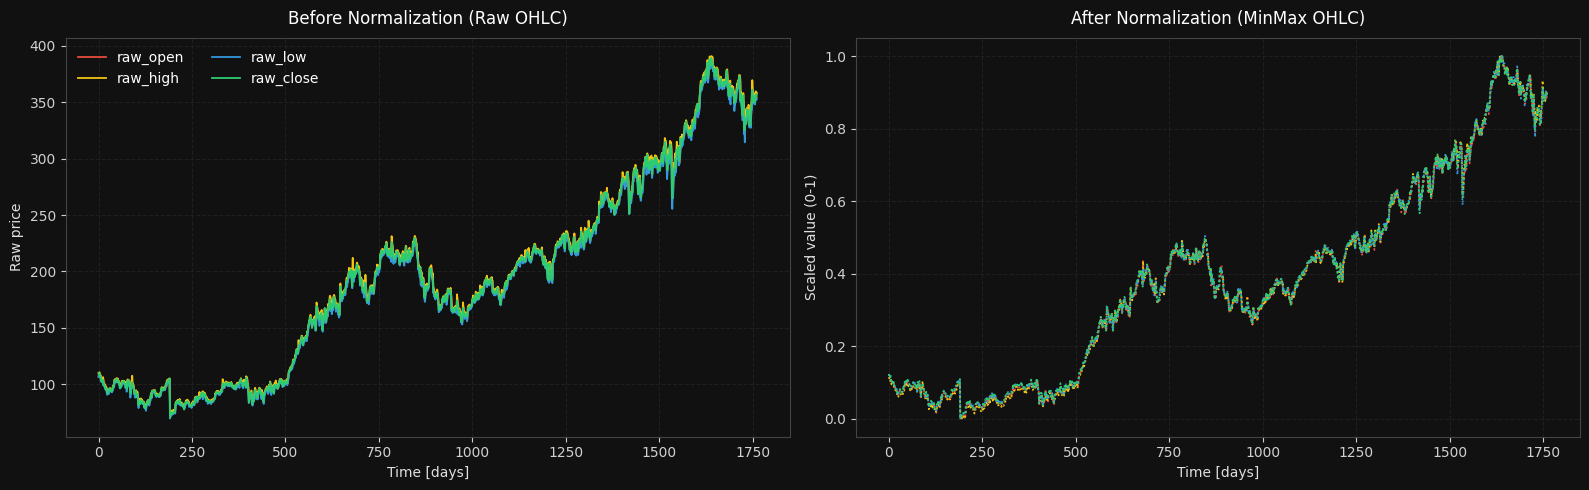

In [8]:
# Preprocessing effect visualization: raw OHLC vs normalized OHLC
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for col, color in zip(MODEL_FEATURES, ["#E74C3C", "#F1C40F", "#3498DB", "#2ECC71"]):
    axes[0].plot(np.arange(len(model_df)), model_df[col].values, label=f"raw_{col}", color=color, linewidth=1.3)

for col, color in zip(MODEL_FEATURES, ["#E74C3C", "#F1C40F", "#3498DB", "#2ECC71"]):
    axes[1].plot(np.arange(len(model_df_norm)), model_df_norm[col].values, label=f"norm_{col}", color=color, linewidth=1.3, linestyle=":")

style_axis(axes[0], title="Before Normalization (Raw OHLC)", xlabel="Time [days]", ylabel="Raw price")
style_axis(axes[1], title="After Normalization (MinMax OHLC)", xlabel="Time [days]", ylabel="Scaled value (0-1)")
axes[0].legend(frameon=False, ncol=2)

plt.tight_layout()
plt.show()


### Neural Network Structure
The following diagram illustrates the exact tensor flow through our Staked LSTM architecture, detailing the dimensionality changes at every step:

```text
                     Stock Price Prediction (Stacked LSTM)
                                      │
              Predicted Close Price ──(Output: 1)
                                      ▲
              [Layer 4: Output]    Dense(1)
                                      ▲
              [Layer 3: Dense]     Dense(25)
                                      ▲
                                      │  ← Single context vector (96,)
  [Layer 2: LSTM]  (h2) ──► (h2) ──► ... ──► (h2) → 96 features
  return_seq=False   ▲       ▲                 ▲
                     │       │                 │
  [Layer 1: LSTM]  (h1) ──► (h1) ──► ... ──► (h1)   96-dim sequence
  return_seq=True    ▲       ▲                 ▲
                     │       │                 │
                  [Open ]  [Open ]           [Open ]
                  [High ]  [High ]           [High ]
                  [Low  ]  [Low  ]           [Low  ]
                  [Close]  [Close]           [Close]
                  [Vol  ]  [Vol  ]           [Vol  ]
                    t=1      t=2    . . .     t=30

                  Input Shape: (30, 5)
```


## 6. Model Architecture and Training
We construct the Deep Learning model using the Keras Functional API. The model includes:
-   Two **LSTM layers** with Dropout regularization to prevent overfitting.
-   **Dense layers** to map the LSTM outputs to the final regression value.
-   **Early Stopping** and **Model Checkpointing** callbacks to save the best weights and halt training if validation loss plateaus.

In [9]:
n_steps = SEQUENCE_LENGTH - 1
n_inputs = 4
n_outputs = 4

lstm_model = Sequential(name="nyse_lstm_ohlc")
lstm_model.add(Input(shape=(n_steps, n_inputs), name="sequence_input"))

for idx in range(LSTM_LAYERS):
    ret_seq = idx < (LSTM_LAYERS - 1)
    lstm_model.add(LSTM(LSTM_UNITS, return_sequences=ret_seq))
    lstm_model.add(Dropout(DROPOUT_RATE))

lstm_model.add(Dense(n_outputs))
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

best_path = ARTIFACT_DIR / "best_lstm.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ModelCheckpoint(filepath=str(best_path), monitor="val_loss", save_best_only=True),
]

history = lstm_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks,
)



Epoch 1/40


2026-02-18 21:16:20.103526: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0513 - val_loss: 0.0053
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0010 - val_

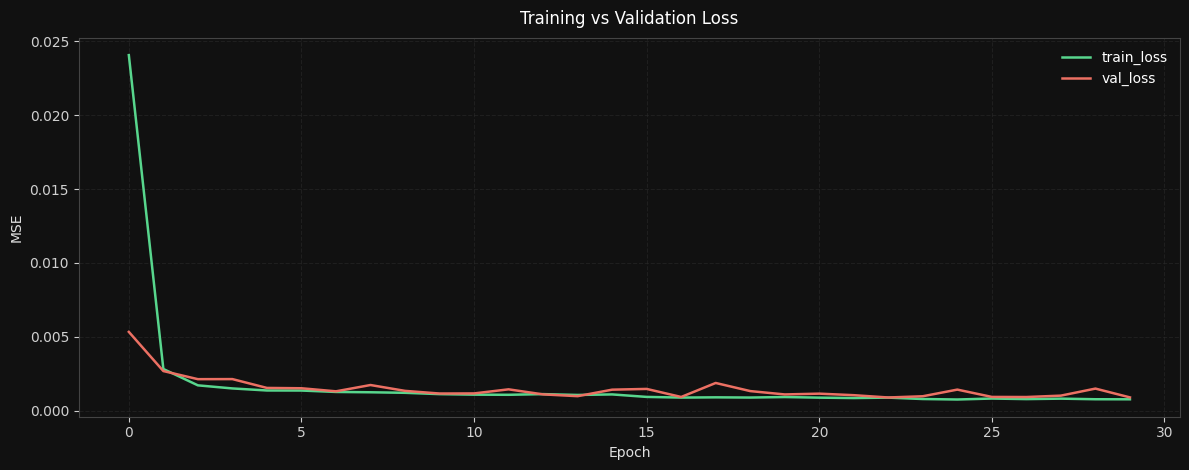

In [10]:
fig, ax = plt.subplots(figsize=(12, 4.8))
ax.plot(history.history["loss"], label="train_loss", color="#58D68D", linewidth=1.8)
ax.plot(history.history["val_loss"], label="val_loss", color="#EC7063", linewidth=1.8)
style_axis(ax, title="Training vs Validation Loss", xlabel="Epoch", ylabel="MSE")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


## 7. Performance Evaluation
Once trained, we generate predictions on the Training, Validation, and Test sets. We evaluate the model using:
-   **MAE & RMSE**: To measure the average magnitude of the prediction error.
-   **Directional Accuracy**: To assess the model's ability to correctly classify the direction of the next day's price movement (Up vs. Down), a crucial metric for trading strategies.

In [11]:
y_train_pred = lstm_model.predict(x_train, verbose=0)
y_valid_pred = lstm_model.predict(x_valid, verbose=0)
y_test_pred = lstm_model.predict(x_test, verbose=0)

feature_index_map = {name: i for i, name in enumerate(MODEL_FEATURES)}
ft = feature_index_map["open"]  # plotted feature index
idx_open = feature_index_map["open"]
idx_close = feature_index_map["close"]

mae = mean_absolute_error(y_test[:, ft], y_test_pred[:, ft])
rmse = np.sqrt(mean_squared_error(y_test[:, ft], y_test_pred[:, ft]))

corr_price_development_train = np.mean(np.sign(y_train[:, idx_close]-y_train[:, idx_open]) == np.sign(y_train_pred[:, idx_close]-y_train_pred[:, idx_open]))
corr_price_development_valid = np.mean(np.sign(y_valid[:, idx_close]-y_valid[:, idx_open]) == np.sign(y_valid_pred[:, idx_close]-y_valid_pred[:, idx_open]))
corr_price_development_test = np.mean(np.sign(y_test[:, idx_close]-y_test[:, idx_open]) == np.sign(y_test_pred[:, idx_close]-y_test_pred[:, idx_open]))

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print('correct sign prediction for close-open train/valid/test: %.2f/%.2f/%.2f' % (
    corr_price_development_train,
    corr_price_development_valid,
    corr_price_development_test,
))



MAE: 0.018641
RMSE: 0.023467
correct sign prediction for close-open train/valid/test: 0.53/0.36/0.39


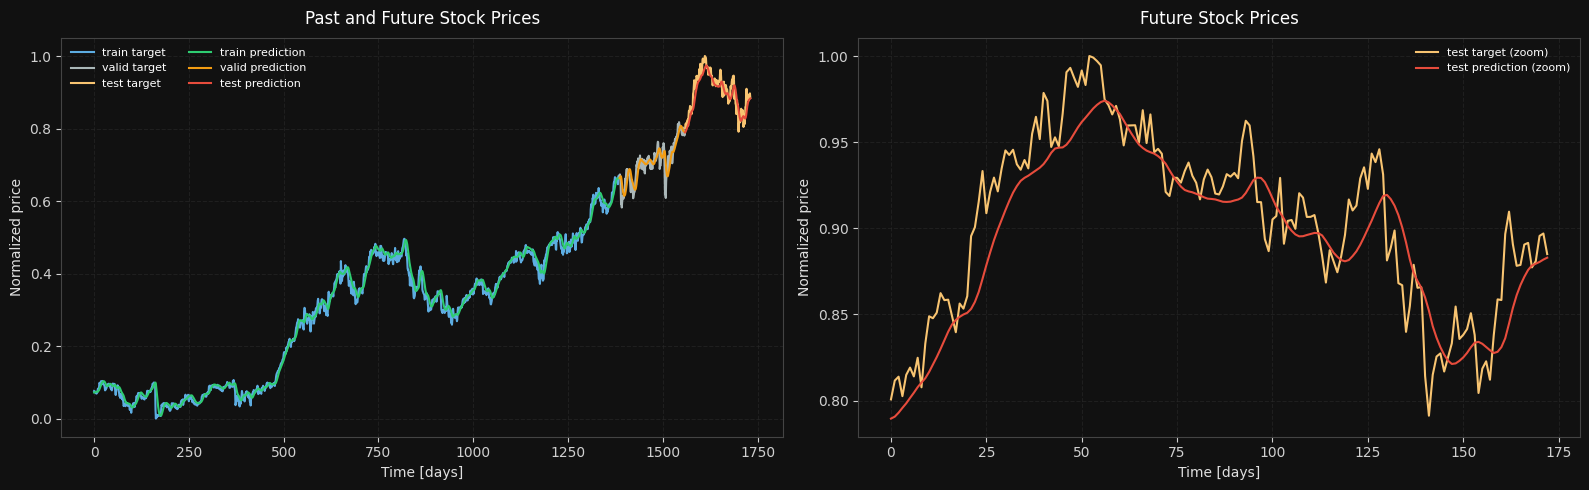

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(np.arange(y_train.shape[0]), y_train[:, ft], label="train target", color="#5DADE2")
axes[0].plot(np.arange(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]), y_valid[:, ft], label="valid target", color="#AAB7B8")
axes[0].plot(
    np.arange(y_train.shape[0] + y_valid.shape[0], y_train.shape[0] + y_valid.shape[0] + y_test.shape[0]),
    y_test[:, ft],
    label="test target",
    color="#F8C471",
)

axes[0].plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft], label="train prediction", color="#2ECC71")
axes[0].plot(
    np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0]),
    y_valid_pred[:, ft],
    label="valid prediction",
    color="#F39C12",
)
axes[0].plot(
    np.arange(y_train_pred.shape[0] + y_valid_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
    y_test_pred[:, ft],
    label="test prediction",
    color="#E74C3C",
)
style_axis(axes[0], title="Past and Future Stock Prices", xlabel="Time [days]", ylabel="Normalized price")
axes[0].legend(frameon=False, fontsize=8, ncol=2)

axes[1].plot(np.arange(y_test.shape[0]), y_test[:, ft], label="test target (zoom)", color="#F8C471")
axes[1].plot(np.arange(y_test_pred.shape[0]), y_test_pred[:, ft], label="test prediction (zoom)", color="#E74C3C")
style_axis(axes[1], title="Future Stock Prices", xlabel="Time [days]", ylabel="Normalized price")
axes[1].legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()


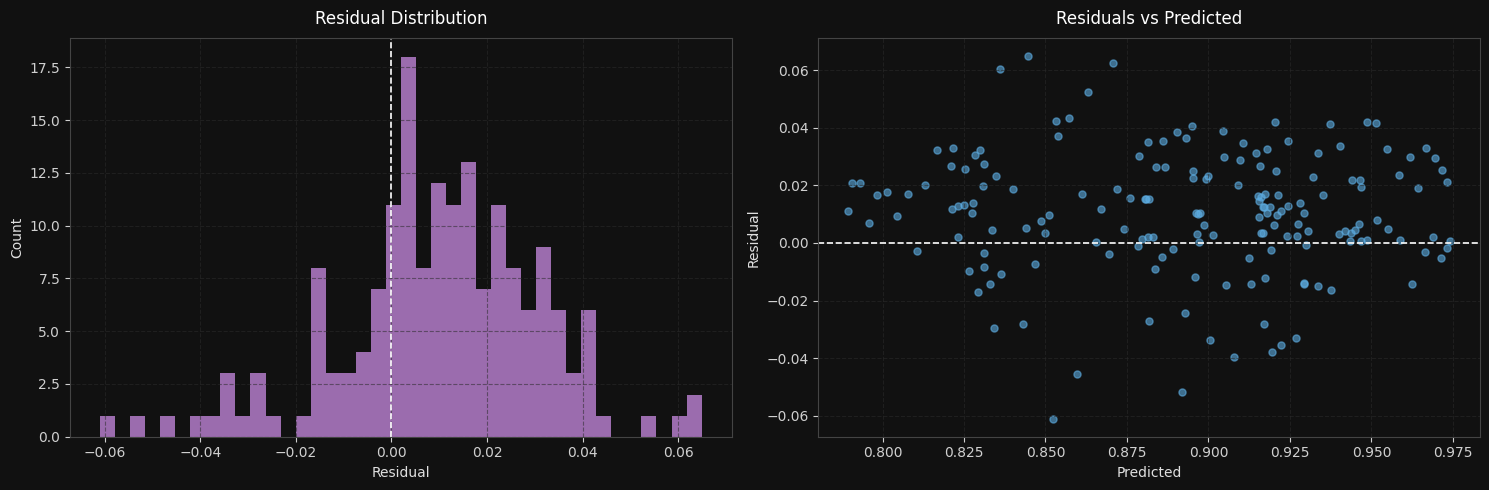

In [13]:
residuals = y_test[:, ft] - y_test_pred[:, ft]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(residuals, bins=40, color="#AF7AC5", alpha=0.88)
axes[0].axvline(0, color="white", linestyle="--", linewidth=1.2)
style_axis(axes[0], title="Residual Distribution", xlabel="Residual", ylabel="Count")

axes[1].scatter(y_test_pred[:, ft], residuals, s=26, alpha=0.6, color="#5DADE2")
axes[1].axhline(0, color="white", linestyle="--", linewidth=1.2)
style_axis(axes[1], title="Residuals vs Predicted", xlabel="Predicted", ylabel="Residual")

plt.tight_layout()
plt.show()


## 8) Export for Deployment


In [14]:
model_path = ARTIFACT_DIR / "nyse_lstm_ohlc.keras"
lstm_model.save(model_path)

config = {
    "ticker": TICKER,
    "feature_columns": FEATURE_COLUMNS,
    "target_column": TARGET_COLUMN,
    "sequence_length": SEQUENCE_LENGTH,
    "lstm_units": LSTM_UNITS,
    "lstm_layers": LSTM_LAYERS,
    "dropout_rate": DROPOUT_RATE,
}

(ARTIFACT_DIR / "config.json").write_text(json.dumps(config, indent=2), encoding="utf-8")

preprocess_meta = {
    "normalization": "column-wise MinMax on OHLC",
    "columns": ["open", "high", "low", "close"],
}
with open(ARTIFACT_DIR / "preprocess_meta.pkl", "wb") as f:
    pickle.dump(preprocess_meta, f)

print("Saved artifacts:")
for fpath in sorted(ARTIFACT_DIR.glob("*")):
    print("-", fpath)


Saved artifacts:
- /kaggle/working/nyse_lstm_artifacts/best_lstm.keras
- /kaggle/working/nyse_lstm_artifacts/config.json
- /kaggle/working/nyse_lstm_artifacts/nyse_lstm_ohlc.keras
- /kaggle/working/nyse_lstm_artifacts/preprocess_meta.pkl


## 9) Inference Utility


In [15]:
def predict_next_ohlc(model, normalized_window, seq_len=SEQUENCE_LENGTH):
    # normalized_window expected shape: (seq_len - 1, 4)
    x = np.asarray(normalized_window, dtype=np.float32)
    expected = (seq_len - 1, 4)
    if x.shape != expected:
        raise ValueError(f"Expected {expected}, got {x.shape}")

    pred = model.predict(x.reshape(1, seq_len - 1, 4), verbose=0)
    return pred.reshape(-1)

# Example:
# next_pred = predict_next_ohlc(lstm_model, x_test[0])
# print(next_pred)


## 10) Final Notes
- Change `TICKER` and rerun from top to retrain for another stock.
- Artifacts are written to `/kaggle/working/nyse_lstm_artifacts`.
- Keep sequence formatting identical during training and inference.


## 11. Targeted Ticker Analysis (VZ & WAT)
In this final section, we validate the pipeline's robustness by applying it to specific tickers of interest. We perform independent data splitting, training, and visualization for **Verizon (VZ)** and **Waters Corporation (WAT)** to demonstrate the model's adaptability.

In [16]:
def run_ticker_pipeline(symbol, df, seq_len=30, epochs=10):
    print(f"\nProcessing {symbol}...")

    # 1. Data Prep
    tdf = df[df["symbol"] == symbol].sort_values("date").reset_index(drop=True)
    if len(tdf) < seq_len + 100:
        print(f"Not enough data for {symbol}")
        return

    data = tdf[FEATURE_COLUMNS].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    target_idx = FEATURE_COLUMNS.index(TARGET_COLUMN)

    X, y = [], []
    for i in range(seq_len, len(scaled_data)):
        X.append(scaled_data[i - seq_len:i])
        y.append(scaled_data[i, target_idx])

    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    # 80/10/10 Split logic to match the requested visualization structure
    N = len(X)
    train_size = int(N * 0.80)
    valid_size = int(N * 0.10)

    X_train, y_train = X[:train_size], y[:train_size]
    X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
    X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

    # 2. Build New Model (Fresh for each ticker)
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(LSTM_UNITS, return_sequences=True),
        Dropout(DROPOUT_RATE),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dropout(DROPOUT_RATE),
        Dense(25),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")

    # 3. Train
    print(f"Training model for {symbol}...")
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(X_valid, y_valid),
        verbose=0,
        callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    )

    # 4. Predict
    y_train_pred = model.predict(X_train, verbose=0)
    y_valid_pred = model.predict(X_valid, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    # 5. Visualize using requested structure
    ft = 0  # y has shape (N, 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Panel 1: Full Timeline
    axes[0].plot(np.arange(y_train.shape[0]), y_train[:, ft], label="train target", color="#5DADE2")
    axes[0].plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft], label="train prediction", color="#2ECC71")

    valid_start = y_train.shape[0]
    axes[0].plot(
        np.arange(valid_start, valid_start + y_valid.shape[0]),
        y_valid[:, ft],
        label="valid target",
        color="#AAB7B8",
    )
    axes[0].plot(
        np.arange(valid_start, valid_start + y_valid_pred.shape[0]),
        y_valid_pred[:, ft],
        label="valid prediction",
        color="#F39C12",
    )

    test_start = valid_start + y_valid.shape[0]
    axes[0].plot(
        np.arange(test_start, test_start + y_test.shape[0]),
        y_test[:, ft],
        label="test target",
        color="#F8C471",
    )
    axes[0].plot(
        np.arange(test_start, test_start + y_test_pred.shape[0]),
        y_test_pred[:, ft],
        label="test prediction",
        color="#E74C3C",
    )

    # Panel 2: Zoom on Test
    axes[1].plot(np.arange(y_test.shape[0]), y_test[:, ft], label="test target (zoom)", color="#F8C471")
    axes[1].plot(np.arange(y_test_pred.shape[0]), y_test_pred[:, ft], label="test prediction (zoom)", color="#E74C3C")

    style_axis(axes[0], title=f"Results for {symbol} - Past and Future Stock Prices", xlabel="Time [days]", ylabel="Normalized price")
    style_axis(axes[1], title=f"Results for {symbol} - Future Stock Prices", xlabel="Time [days]", ylabel="Normalized price")
    axes[0].legend(frameon=False, fontsize=8, ncol=2)
    axes[1].legend(frameon=False, fontsize=8)

    plt.tight_layout()
    plt.show()


Analyzing Specific Tickers: ['VZ']

Processing VZ...
Training model for VZ...


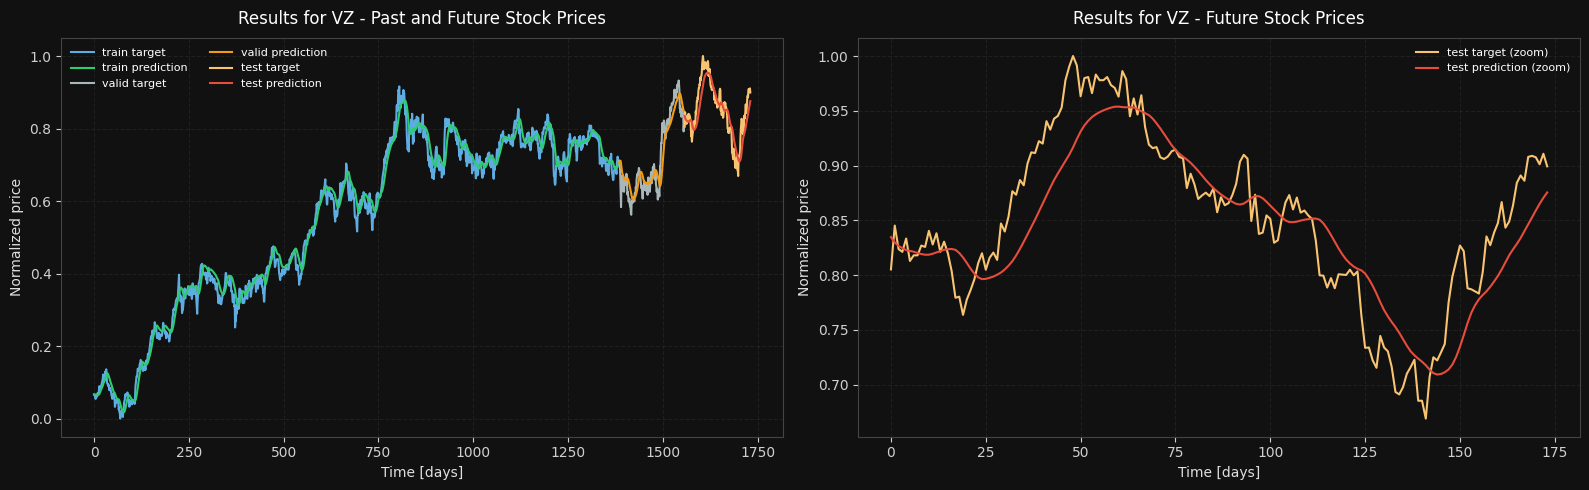

In [17]:
# Define specific tickers for analysis
target_tickers = ['VZ']
print(f"Analyzing Specific Tickers: {target_tickers}")

for sym in target_tickers:
    try:
        run_ticker_pipeline(sym, market_df, seq_len=SEQUENCE_LENGTH, epochs=20)
    except Exception as e:
        print(f"Error processing {sym}: {e}")

## 13. Architectural Decisions & Technical Q&A

### Q1: Why choose a Stacked LSTM over a Vanilla LSTM or other architectures (like GRU/RNN)?
**Answer:**
The primary advantage is **Hierarchical Feature Learning**.
- **Vanilla LSTM:** Effective at learning temporal dependencies but limited to a single level of abstraction.
- **Stacked LSTM:** Mimics the "Deep" structure of Deep Learning. 
  - **Layer 1 (Feature Extractor)**: Identifies raw temporal, low-level patterns effectively (e.g., volatility spikes, immediate momentum).
  - **Layer 2 (Pattern Integrator)**: Takes the *sequence of patterns* from Layer 1 as input (rather than raw prices). It models higher-level, slower-moving concepts like "Trend Reversal" or "Consolidation". This depth allows the model to capture complex, non-linear market regimes that a shallow network would miss.

### Q2: Technically, why defines the usage of `return_sequences=True` in Layer 1 vs `False` in Layer 2?
**Answer:**
This parameter controls the tensor dimensionality flow required for stacking:
- **Layer 1 (`return_sequences=True`)**: Outputs the full sequence of hidden states $(h_1, h_2, ..., h_{30})$ resulting in a 3D tensor of shape `(Batch, 30, 96)`. This preserves the **time dimension**, ensuring the next layer sees the data as a sequence.
- **Layer 2 (`return_sequences=False`)**: Outputs only the final hidden state $h_{30}$, resulting in a 2D tensor of shape `(Batch, 96)`. This effectively **encodes** the entire time-series window into a single fixed-length context vector, which is required for the subsequent Dense (fully connected) layers to perform the final regression.

### Q3: How does the LSTM Cell State ($C_t$) technically mitigate the Vanishing Gradient problem during Backpropagation?
**Answer:**
In standard RNNs, gradients multiply through the derivative of the activation function (tanh) at every time step, causing them to decay exponentially (vanish) over long sequences.
- **The Technical Fix**: The LSTM Cell State acts as a **Linear Residual Connection** highway.
- **Mechanism**: During Backpropagation Through Time (BPTT), the gradient flows through the Cell State ($C_t$) via primarily **additive** operations rather than multiplicative ones. The "Forget Gate" regulates this flow linearly. If the gate is open (near 1.0), the error signal propagates back through time unattenuated, allowing the network to learn dependencies from Day 1 just as strongly as Day 30.